# Record Data

## Telemetry
Robots navigate using sensors to perceive the world around them. In this project your analysis will be focused on image data coming from a camera mounted on the front of the rover. However, you will also have access to other data including the rover's position, throttle, brake, steering angle and speed, as well as roll, pitch and yaw angles. If you're unfamiliar with roll, pitch and yaw here's [a post with some helpful explanations](https://robotics.stackexchange.com/questions/1051/what-are-human-friendly-terms-for-mobile-robot-orientation-and-relative-directio).

Collectively, we'll refer to all this data as [telemetry](https://en.wikipedia.org/wiki/Telemetry). If you're interacting with a real robot, you might be receiving telemetry data via WiFi or some other method. You can think of the telemetry data coming from the rover in this project as really just a bunch of sensor readings that are analogous to data you might get from a real rover using real sensors. In addition to the camera images showing the front view from the rover, a GPS might give you position, an inertial measurement unit (IMU) might give you roll, pitch and yaw etc.

Of course, in the real world each sensor reading has [noise](https://en.wikipedia.org/wiki/Noise_(signal_processing%29) associated with it, meaning the measurement is uncertain. In a typical application, you need to account for noise in sensor measurements, but for this project we'll pretend we have perfect sensors!

# The Perception Step
Goal: to define the route by finding edges of light area on a picture made from rover's camera.

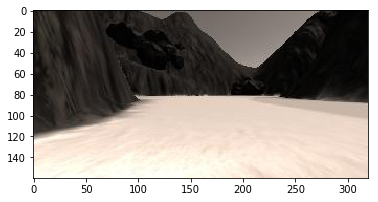

In [2]:
# Import some packages from matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
# Uncomment the next line for use in a Jupyter notebook
%matplotlib inline

# Define the filename, read and plot the image
filename = 'img/sample.jpg'
image = mpimg.imread(filename)
plt.imshow(image)
plt.show()

Now you have your image stored as an array and you can perform operations on it. First off, you can explore what it's size and datatype are, as well as the minimum and maximum values in the array using the numpy package (and check out this [crash course on using numpy with images](http://scikit-image.org/docs/dev/user_guide/numpy_images.html) for more details on the direction we're going here):

In [3]:
# Import the "numpy" package for working with arrays
import numpy as np
print(image.dtype, image.shape, np.min(image), np.max(image))
# uint8 (160, 320, 3) 0 255

uint8 (160, 320, 3) 0 255


Investigating different color channels of image in isolation.

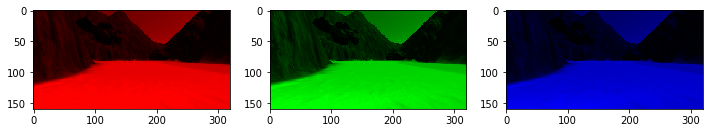

In [4]:
# Note: we use the np.copy() function rather than just saying red_channel = image
# because in Python, such a statement would set those two arrays equal to each other
# forever, meaning any changes made to one would also be made to the other!
red_channel = np.copy(image)
# Note: here instead of extracting individual channels from the image
# I'll keep all 3 color channels in each case but set the ones I'm not interested 
# in to zero.  
red_channel[:,:,[1, 2]] = 0 # Zero out the green and blue channels
green_channel = np.copy(image)
green_channel[:,:,[0, 2]] = 0 # Zero out the red and blue channels
blue_channel = np.copy(image)
blue_channel[:,:,[0, 1]] = 0 # Zero out the red and green channels
fig = plt.figure(figsize=(12,3)) # Create a figure for plotting
plt.subplot(131) # Initialize subplot number 1 in a figure that is 3 columns 1 row
plt.imshow(red_channel) # Plot the red channel
plt.subplot(132) # Initialize subplot number 2 in a figure that is 3 columns 1 row
plt.imshow(green_channel)  # Plot the green channel
plt.subplot(133) # Initialize subplot number 3 in a figure that is 3 columns 1 row
plt.imshow(blue_channel)  # Plot the blue channel
# plt.show()

While the mountains are relatively dark (low intensity values) in all three color channels, both the ground and the sky are brighter (higher intensity) in the red, green and blue channels. However, in all cases it looks like the ground is a bit brighter than the sky, such that it should be possible to identify pixels associated with the ground using a simple color threshold.

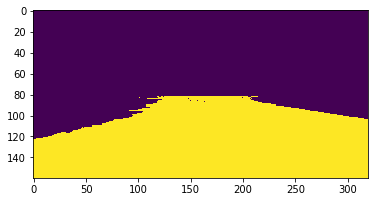

In [5]:
# Define a function to perform a color threshold
def color_thresh(img, rgb_thresh=(0, 0, 0)):
    ####### TODO 
    # Create an empty array the same size in x and y as the image 
    # but just a single channel
    binary_image = np.zeros_like(img[:,:,0])

    # Apply the thresholds for RGB and 
    # assign 1's where threshold was exceeded
    above_thresh = (img[:,:,0] > rgb_thresh[0]) \
                & (img[:,:,1] > rgb_thresh[1]) \
                & (img[:,:,2] > rgb_thresh[2])
    binary_image[above_thresh] = 1
    return binary_image

fig = plt.figure()
plt.imshow(color_thresh(image, (180, 180, 180)))
plt.show()

# Perspective Transform

<IPython.core.display.Javascript object>


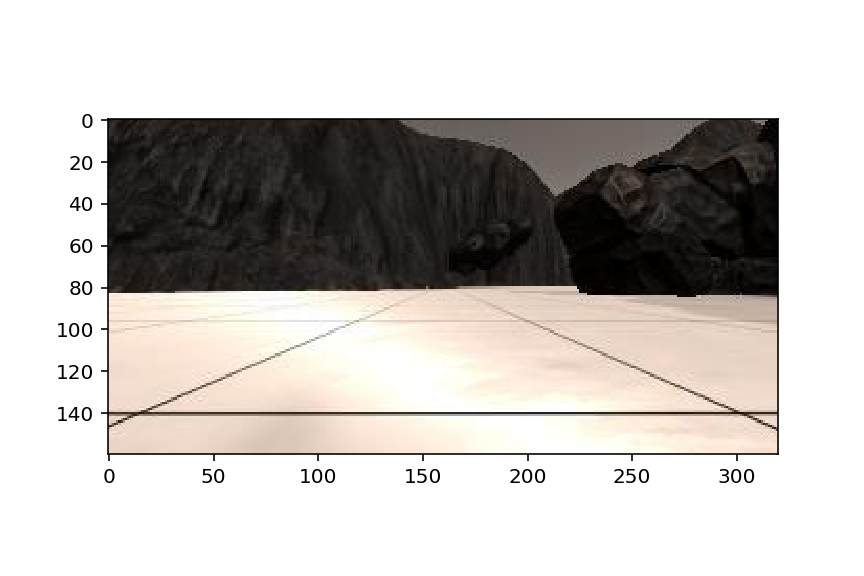

In [7]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
# Uncomment the next line for use in a Jupyter notebook
# This enables the interactive matplotlib window
%matplotlib notebook
image = mpimg.imread('img/example_grid1.jpg')
plt.figure()
plt.imshow(image)
# plt.show()

First, you need to select four points in your "source" image and map them to four points in our "destination" image, which will be the top-down view. The grid squares on the ground in the simulator represent 1 meter square each so this mapping will also provide us with a distance estimate to everything in the ground plane in the field of view.

Perspective transforms involve some complicated geometry but here you'll use the OpenCV functions `cv2.getPerspectiveTransform()` and `cv2.warpPerspective()` to do the heavy lifting (for more on this and other geometric transforms you can do with OpenCV, check out [this page](http://docs.opencv.org/trunk/da/d6e/tutorial_py_geometric_transformations.html)). 

<IPython.core.display.Javascript object>


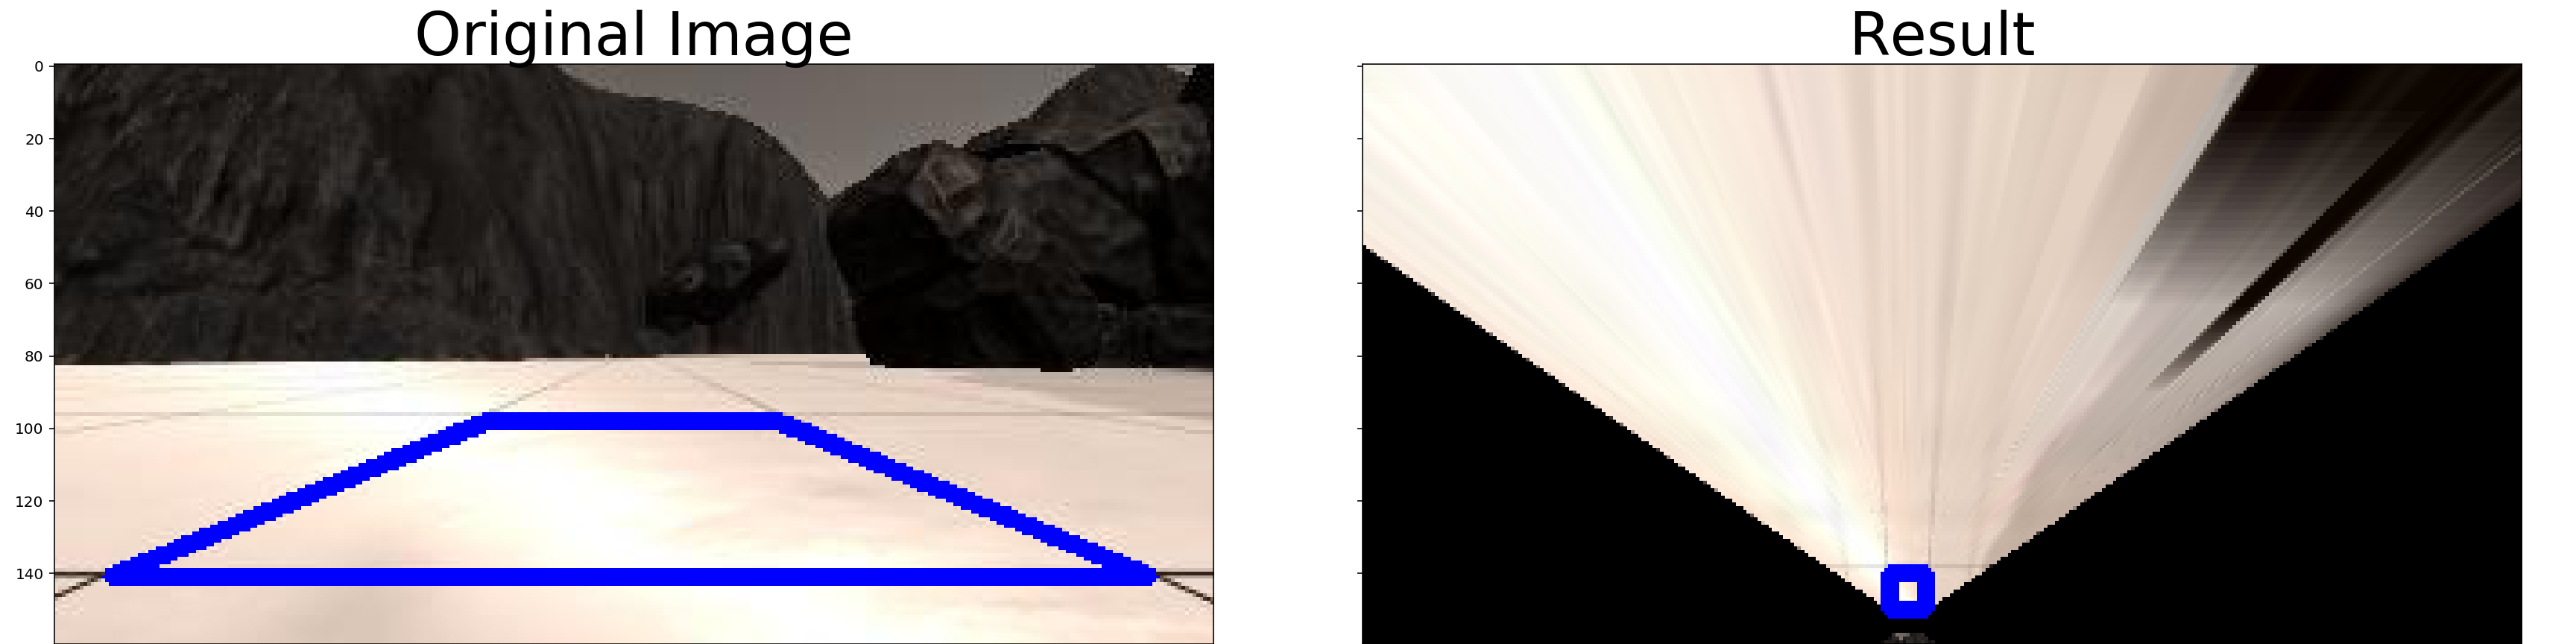

In [11]:
import cv2
import numpy as np

def perspect_transform(img, src, dst):
    # Get transform matrix using cv2.getPerspectivTransform()
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp image using cv2.warpPerspective()
    # keep same size as input image
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))
    # Return the result
    return warped

# Define source and destination points
source = np.float32([[ 15, 141 ], [ 119, 98 ], [ 199, 98 ], [ 302, 141 ]])
destination = np.float32([[ 145, 150 ], [ 145, 140 ], [ 155, 140 ], [ 155, 150 ]])

warped = perspect_transform(image, source, destination)

# Draw Source and destination points on images (in blue) before plotting
cv2.polylines(image, np.int32([source]), True, (0, 0, 255), 3)
cv2.polylines(warped, np.int32([destination]), True, (0, 0, 255), 3)
# Display the original image and binary               
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 6), sharey=True)
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(warped, cmap='gray')
ax2.set_title('Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

# Warp, Threshold, and Map to Rover-Centric Coordinates

From a raw image to navigable terrain in rover-centric coordinates:

<img src="img/screen-shot-2017-05-02-at-2.28.19-pm.png">

Apply a perspective transform and then apply a color threshold to make a map of the environment. This color thresholded image is now a map of the navigable terrain in front of the rover.

<IPython.core.display.Javascript object>


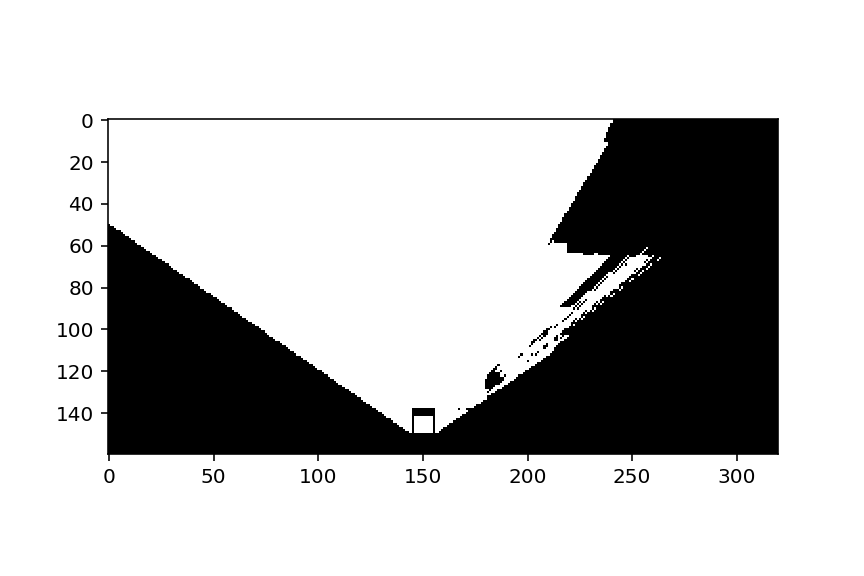

In [13]:
warped = perspect_transform(image, source, destination)

colorsel = color_thresh(warped, rgb_thresh=(160, 160, 160))

# Plot the result
plt.figure()
plt.imshow(colorsel, cmap='gray')
plt.show()

## Converting to Rover-Centric Coordinates
The notion of a coordinate system that is fixed with respect to your robot is central to many robotics applications. Such a coordinate system allows you to describe the positions of things in the environment with respect to the robot, in this case, the rover (or more specifically, the rover's camera).

Next is an extraction of the pixel positions of all navigable terrain (white) pixels and a transformation of those values to "rover-centric" coordinates, meaning a coordinate frame where the rover camera is at $$(x, y) = (0, 0)$$

<IPython.core.display.Javascript object>


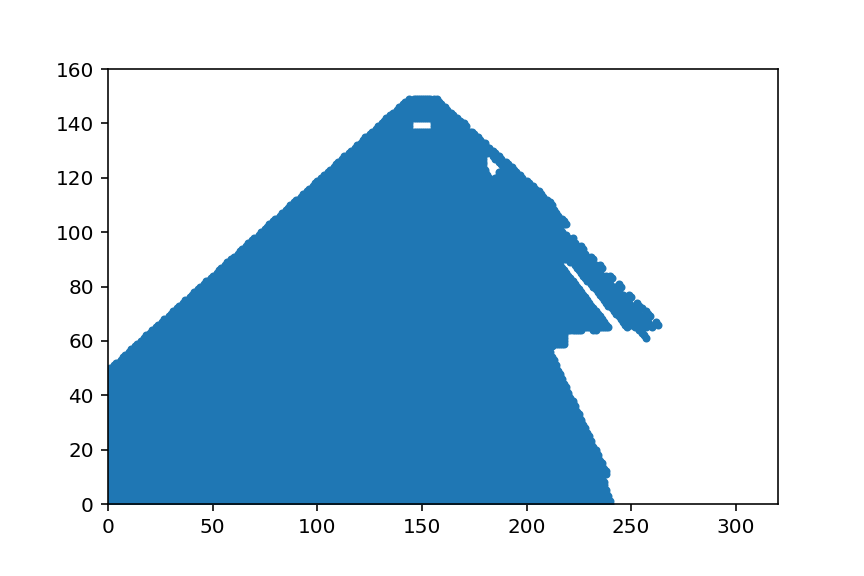

In [14]:
ypos, xpos = colorsel.nonzero()
plt.figure()
plt.plot(xpos, ypos, '.')
plt.xlim(0, 320)
plt.ylim(0, 160)
plt.show()

Whoa! But it's upside-down! This is actually the same plot / image as before, we're just looking at it with the origin `(0, 0)` in the lower left, rather than the upper left, and the $y$-axis reversed.

Now you have $x$ and $y$ pixel positions in image space of the navigable terrain and all you need to do is convert it to rover-centric coordinates. However, you would also like to swap the $x$ and $y$ axes such that they're consistent with the world coordinate system that you'll eventually be mapping to. The image below shows both the rover-centric coordinate system we will define, and the world coordinate system, which is the reference frame that is fixed with respect to the world and that you will later be mapping to:

<img src="img/screen-shot-2017-05-21-at-1.12.06-pm.png">

Now a function to take in a binary image, extract the x and y positions in image coordinates and then return x and y in rover coordinates.

<IPython.core.display.Javascript object>


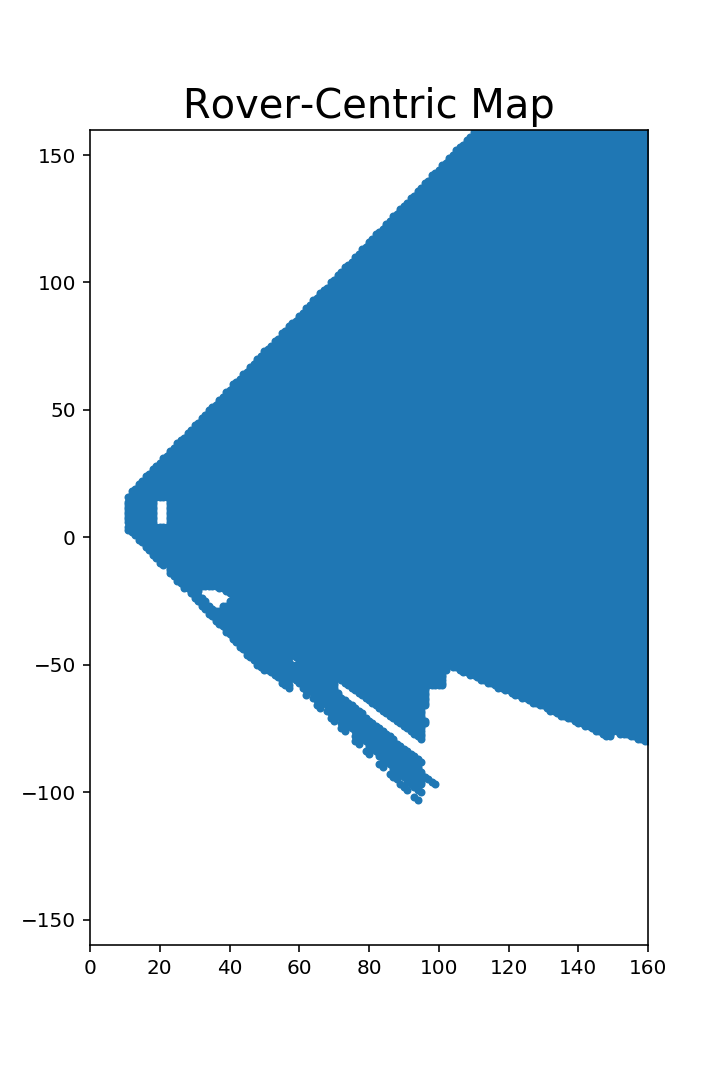

In [15]:
def rover_coords(binary_img):
    # Extract xpos and ypos pixel positions from binary_img and
    # Convert xpos and ypos to rover-centric coordinates
    ypos, xpos = binary_img.nonzero()
    
    # Calculate pixel positions with reference to the rover position being at the 
    # center bottom of the image.  
    x_pixel = -(ypos - binary_img.shape[0]).astype(np.float)
    y_pixel = -(xpos - binary_img.shape[1] / 2).astype(np.float)
    
    return x_pixel, y_pixel

# Extract x and y positions of navigable terrain pixels
# and convert to rover coordinates
xpix, ypix = rover_coords(colorsel)

# Plot the map in rover-centric coords
fig = plt.figure(figsize=(5, 7.5))
plt.plot(xpix, ypix, '.')
plt.ylim(-160, 160)
plt.xlim(0, 160)
plt.title('Rover-Centric Map', fontsize=20)
plt.show()

This choice of coordinates might not seem very intuitive, but now when the rover is situated in the world at position $$(x_{world},y_{world})=(0,0)$$ at a yaw angle of zero (yaw is measured counterclockwise from the positive $x$-direction) then the rover's coordinate frame exactly matches the world frame.

# Map to World Coordinates
<img src="img/screen-shot-2017-05-03-at-7.45.26-pm.png">

The environment you will be navigating with the rover in this project is roughly 200 x 200 meters and looks like the image above from a top-down view. The white areas represent the navigable terrain. You will be provided a copy of this map with the project at a resolution of 1 square meter per pixel (same as shown above). Your goal in this exercise is to write code that will allow you to use the rover's position, orientation and camera image to map its environment and compare against this ground truth map!

<img src="img/screen-shot-2017-05-03-at-7.51.28-pm.png">

## Rotation and Translation
Now that you have generated a map of navigable terrain in rover-centric coordinates, the next step is to map those points to world coordinates. To do this, you'll use a [rotation](https://en.wikipedia.org/wiki/Rotation_matrix) followed by a [translation](https://en.wikipedia.org/wiki/Translation_(geometry%29). The rotation is required to account for the fact that when the camera takes a picture, the rover can be pointing in any arbitrary direction, given by it's yaw angle. The translation is to account for the fact that the rover may be located at any position in the world when it takes a picture. So, it's a 2 step process:

1. Rotate the rover-centric coordinates so that the x and y axes are parallel to the axes in world space.
2. Translate the rotated positions by the x and y position values given by the rover's location (position vector) in the world.

Let's start with the rotation. The yaw angle is measured counterclockwise from the positive x-direction like this:

<img src="img/screen-shot-2017-05-21-at-1.26.20-pm.png">

For a rotation through an angle θ, the operation looks like this:
$$\begin{bmatrix} x' \\ y' \end{bmatrix} =
\begin{bmatrix} cos{\theta} & -sin{\theta} \\ sin{\theta} & cos{\theta} \end{bmatrix}
\begin{bmatrix} x \\ y \end{bmatrix}$$

Or written out explicitly it looks like this:
$$x' = x\ cos{\theta} - y\ sin{\theta}$$
$$y' = x\ sin{\theta} + y\ cos{\theta}$$

The next step in mapping to world coordinates is to perform a translation by simply adding the $x$ and $y$ components of the rover's position to the $x'$ and $y'$ values calculated above.

Keep in mind, however, the scale associated with pixels in rover space versus world space. If, for example, you have mapped pixels in rover space such that each represents `0.1 x 0.1 m`, and in your world map each pixel is `1 x 1 m`, then you need to divide your rover space pixel values by 10 before mapping to world space.

Ultimately you would like to add these new pixels to your map, but you may have inadvertently generated values that fall outside your map if the rover was near the edge of the world, so you should also truncate the values to be within the allowable range given by the map size using the `np.clip()` function.

In [16]:
# Define a function to apply a rotation to pixel positions
def rotate_pix(xpix, ypix, yaw):
    # Convert yaw to radians
    yaw_rad = yaw * np.pi / 180
    # Apply a rotation
    x_rotated = xpix * np.cos(yaw_rad) - ypix * np.sin(yaw_rad)
    y_rotated = xpix * np.sin(yaw_rad) + ypix * np.cos(yaw_rad)

    return x_rotated, y_rotated

# Define a function to perform a translation
def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    # Perform translation and convert to integer since pixel values can't be float
    x_world = np.int_(xpos + (xpix_rot / scale))
    y_world = np.int_(ypos + (ypix_rot / scale))
    return x_world, y_world

# Define a function to apply rotation and translation (and clipping)
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Clip to world_size
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    # Return the result
    return x_pix_world, y_pix_world

Xpos = [ 113.48563459] Ypos = [ 156.51828086] Yaw = [ 104.73316705]


<IPython.core.display.Javascript object>


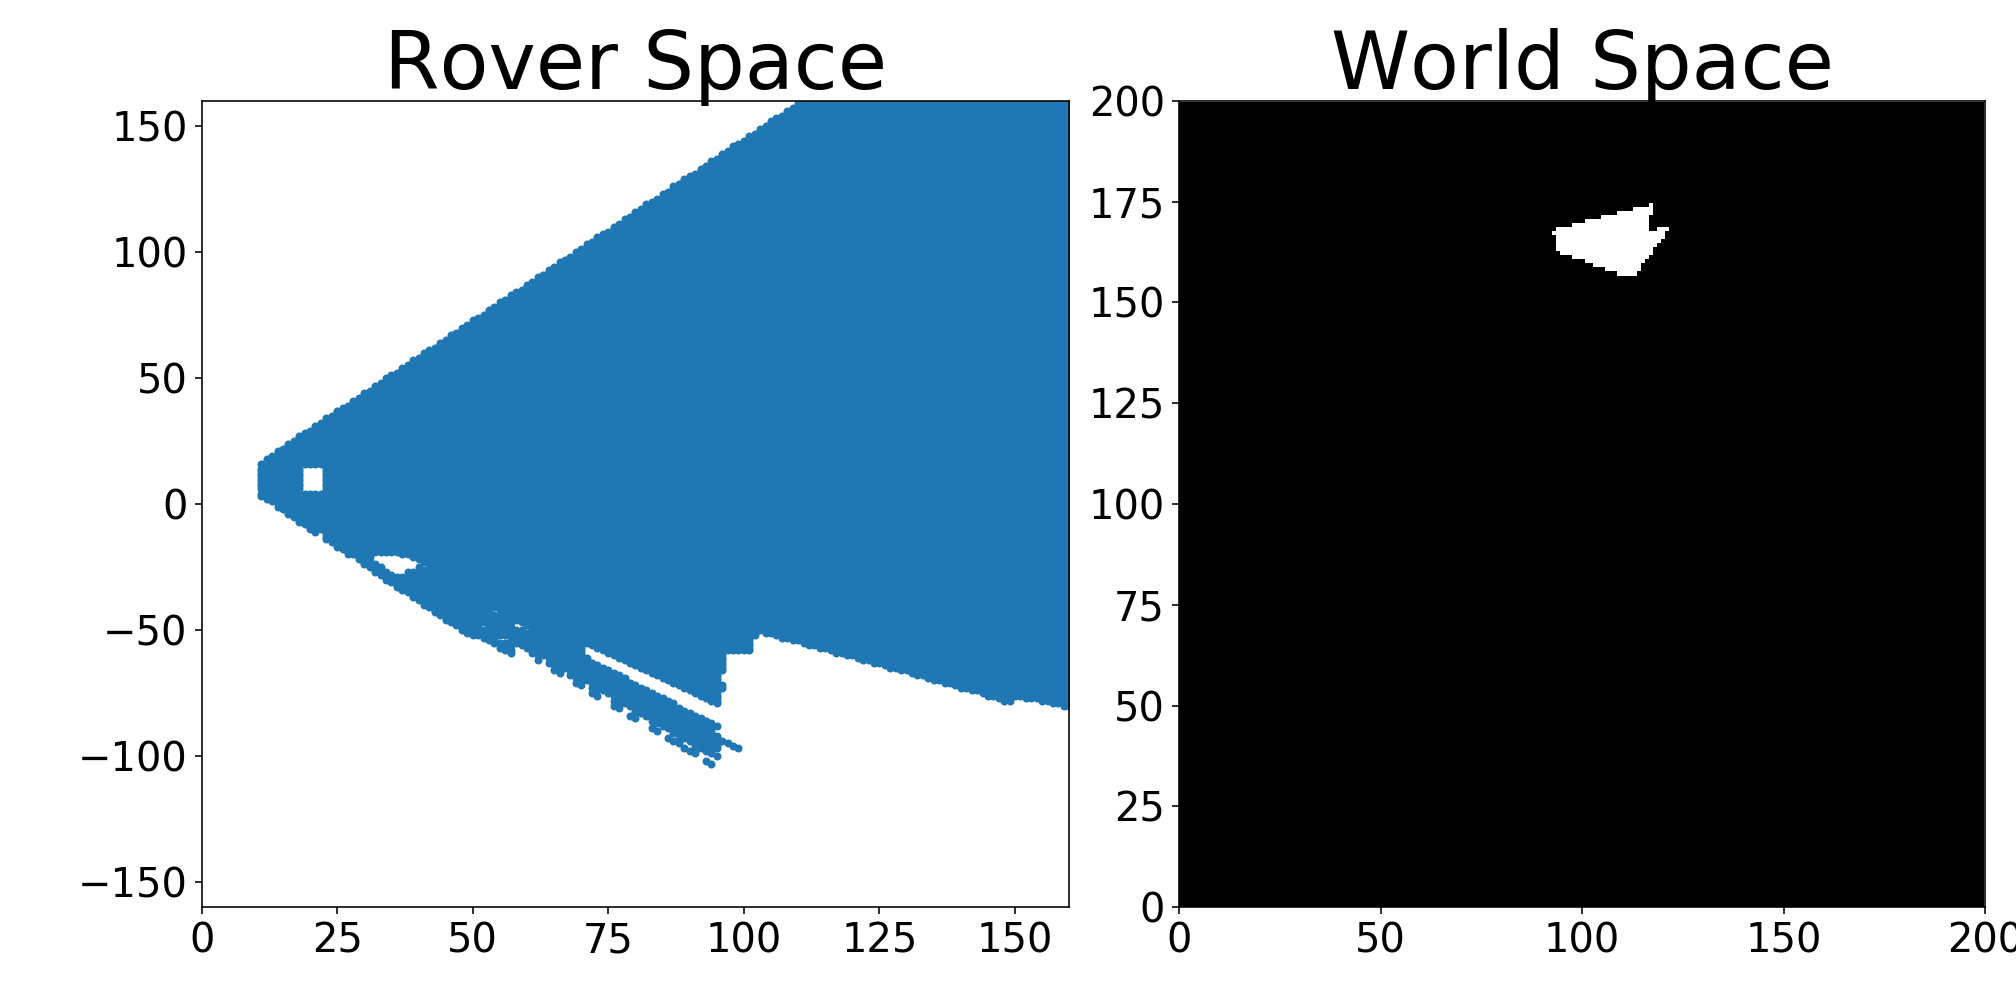

In [17]:
# Rover yaw values will come as floats from 0 to 360
# Generate a random value in this range
# Note: you need to convert this to radians
# before adding to pixel_angles
rover_yaw = np.random.random(1)*360

# Generate a random rover position in world coords
# Position values will range from 20 to 180 to 
# avoid the edges in a 200 x 200 pixel world
rover_xpos = np.random.random(1)*160 + 20
rover_ypos = np.random.random(1)*160 + 20

# Extract navigable terrain pixels
xpix, ypix = rover_coords(colorsel)
# Generate 200 x 200 pixel worldmap
worldmap = np.zeros((200, 200))
scale = 10
# Get navigable pixel positions in world coords
x_world, y_world = pix_to_world(xpix, ypix, rover_xpos, 
                                rover_ypos, rover_yaw, 
                                worldmap.shape[0], scale)
# Add pixel positions to worldmap
worldmap[y_world, x_world] += 1
print('Xpos =', rover_xpos, 'Ypos =', rover_ypos, 'Yaw =', rover_yaw)
# Plot the map in rover-centric coords

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
f.tight_layout()
ax1.plot(xpix, ypix, '.')
ax1.set_title('Rover Space', fontsize=40)
ax1.set_ylim(-160, 160)
ax1.set_xlim(0, 160)
ax1.tick_params(labelsize=20)

ax2.imshow(worldmap, cmap='gray')
ax2.set_title('World Space', fontsize=40)
ax2.set_ylim(0, 200)
ax2.tick_params(labelsize=20)
ax2.set_xlim(0, 200)

plt.subplots_adjust(left=0.1, right=1, top=0.9, bottom=0.1)
plt.show()

# Decision: Where to Go?
<img src="img/spinning-rover.gif">
<p style="text-align: center;">Which way to go?</p>

The goal of this project is to perform autonomous navigation and mapping. You now have the mapping piece and realistically, that means the hard work is done! With each new image you receive from the rover's camera, you will have the opportunity to make a decision about sending commands like throttle, brake and steering. But how to decide what values to send for these commands?

Let's start with steering. There are many ways to approach this, but for starters I'll propose one simple method to decide on a steering angle that will get you up and running with the project. Here we'll consider this image where there is clearly more open ground to the left as seen from the rover's perspective:
<img src="img/angle_example.jpg">

## Average Angle

You have already calculated the x and y positions of navigable terrain pixels in rover space and now you'd like to decide which direction to steer the rover. One simple way to decide is to choose the direction with the clearest path or in other words, the most navigable terrain pixels!

To do this you will first convert your (x, y) pixel positions to [polar coordinates](https://en.wikipedia.org/wiki/Polar_coordinate_system), where each pixel position is represented by its distance from the origin and angle counterclockwise from the positive x-direction.

Converting to polar coordinates:

In [18]:
import numpy as np

# Define a function to convert from cartesian to polar coordinates
def to_polar_coords(xpix, ypix):
    # Calculate distance to each pixel
    dist = np.sqrt(xpix**2 + ypix**2)
    # Calculate angle using arctangent function
    angles = np.arctan2(ypix, xpix)
    return dist, angles

Next calculate direction. The output should be like this:
<img src="img/screen-shot-2017-05-21-at-3.30.58-pm.png">

In [19]:
image = mpimg.imread('img/angle_example.jpg')
source = np.float32([[ 15, 141 ], [ 119, 98 ], [ 199, 98 ], [ 302, 141 ]])
destination = np.float32([[ 145, 150 ], [ 145, 140 ], [ 155, 140 ], [ 155, 150 ]])
warped = perspect_transform(image, source, destination) # Perform perspective transform

In [20]:
colorsel = color_thresh(warped, rgb_thresh=(160, 160, 160)) # Threshold the warped image
xpix, ypix = rover_coords(colorsel)  # Convert to rover-centric coords
distances, angles = to_polar_coords(xpix, ypix) # Convert to polar coords
avg_angle = np.mean(angles) # Compute the average angle

<IPython.core.display.Javascript object>


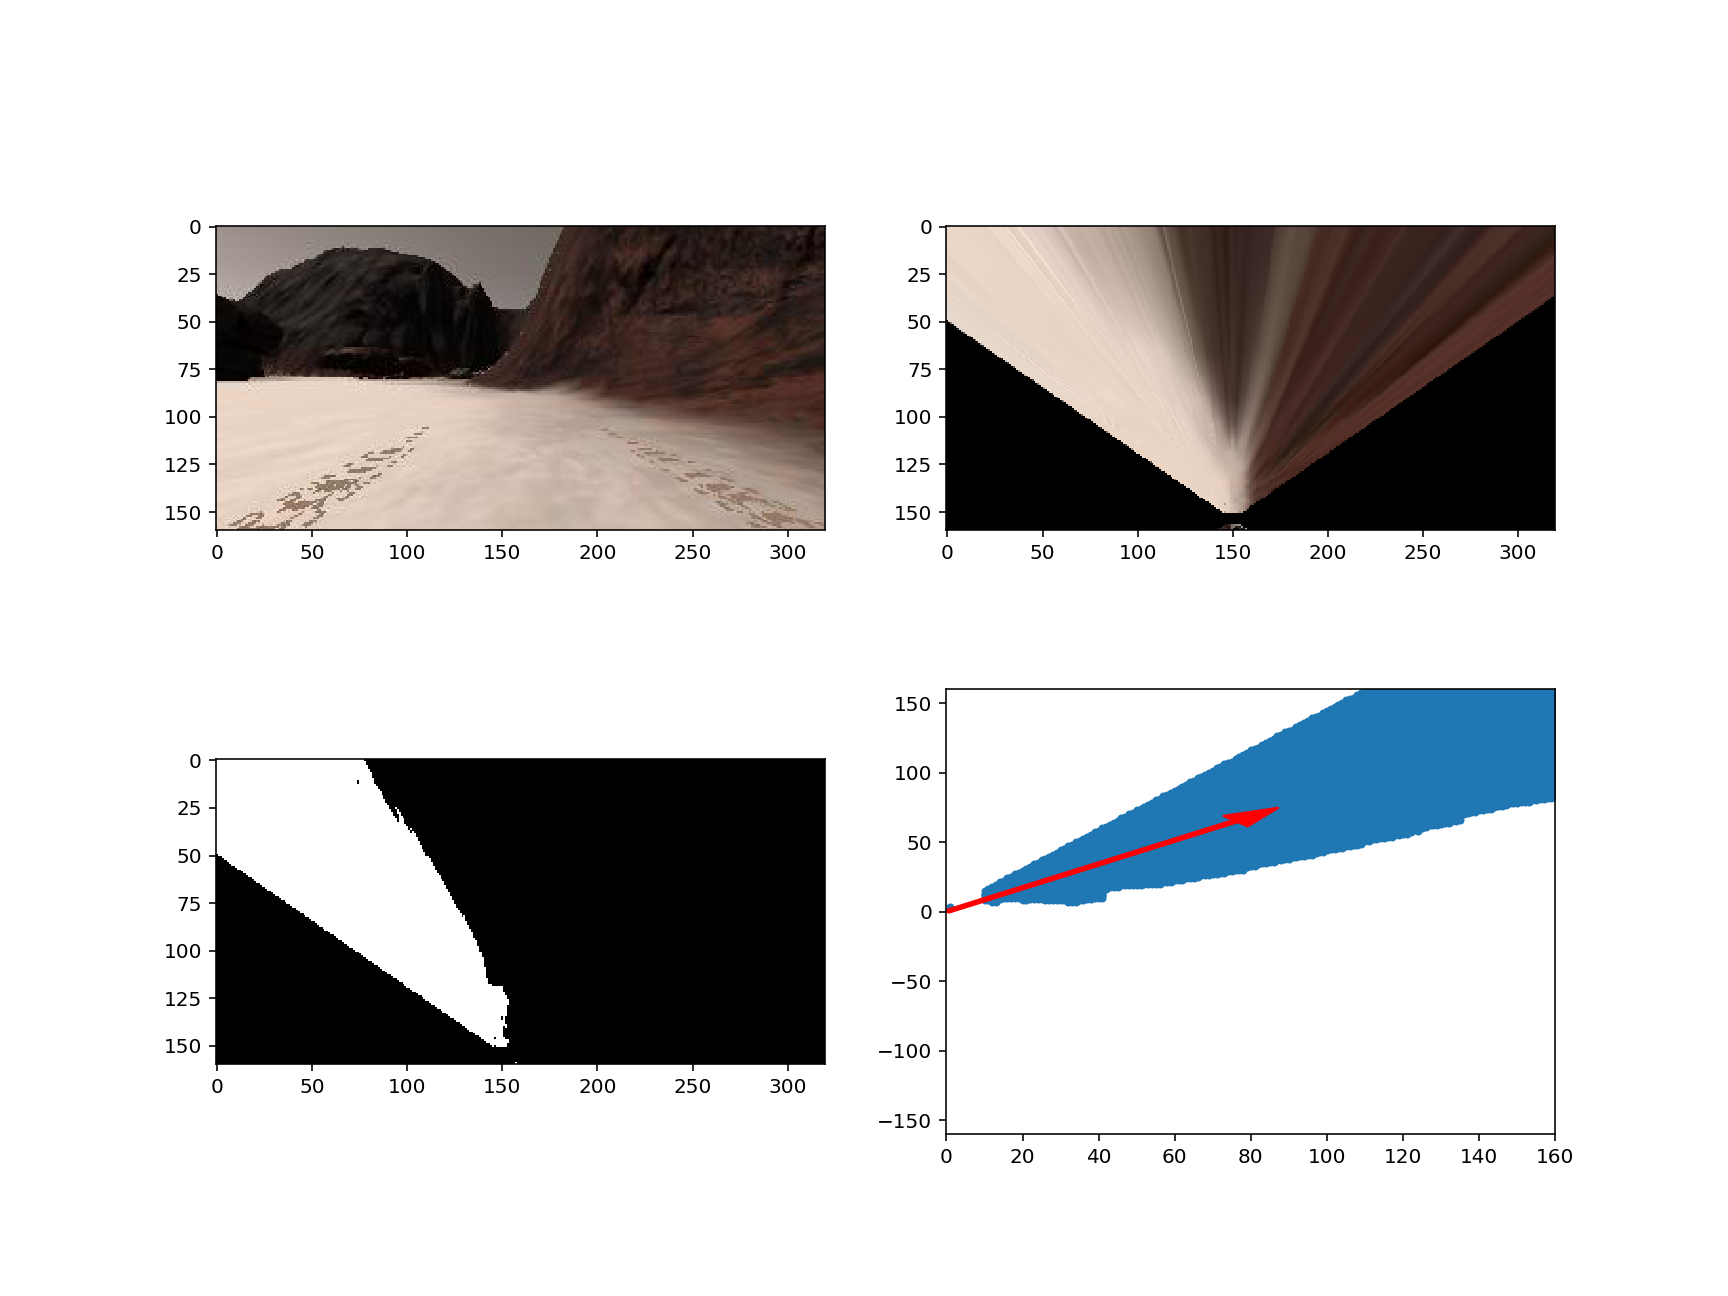

In [21]:
# Do some plotting
fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(image)
plt.subplot(222)
plt.imshow(warped)
plt.subplot(223)
plt.imshow(colorsel, cmap='gray')
plt.subplot(224)
plt.plot(xpix, ypix, '.')
plt.ylim(-160, 160)
plt.xlim(0, 160)
arrow_length = 100
x_arrow = arrow_length * np.cos(avg_angle)
y_arrow = arrow_length * np.sin(avg_angle)
plt.arrow(0, 0, x_arrow, y_arrow, color='red', zorder=2, head_width=10, width=2)
plt.show()

The direction (angle) with that represents the average angle of all navigable terrain pixels in the rover's field of view is at roughly 0.7 radians in the plot above.

Given the approximate field of view of the camera, the average values for angle that you get will vary between about $$\pm\dfrac{\pi}{4}$$ radians. The input for steering angles you can send to the rover is in degrees over the range -15 (to the right) to +15 (to the left), so the last step is to choose a conversion between your average angle and the steering angle you want to send to the rover. The simplest thing to do would be to convert to degrees and clip to the range +/- 15 like this:

In [22]:
avg_angle_degrees = avg_angle * 180/np.pi
steering = np.clip(avg_angle_degrees, -15, 15)
print("Steering angle: ", steering)

Steering angle:  15.0


# More Decisions

<img src="img/screen-shot-2017-04-15-at-4.44.30-pm.png">

There are essentially an infinite number of considerations you could come up with to base your decisions on, but really you could think of any combination of them as a decision tree, like the one above.

This is just a simple example, but as you can imagine, this tree could become very complex, and doesn't necessarily need to be restricted to yes / no scenarios. You could think of this tree as a very basic form of artificial intelligence, where we have simply hardcoded a range of possible scenarios and a decision associated with each. 

In [23]:
# Define RoverState() class to retain rover state parameters
class RoverState():
    def __init__(self):
        self.start_time = None # To record the start time of navigation
        self.total_time = None # To record total duration of naviagation
        self.img = None # Current camera image
        self.pos = None # Current position (x, y)
        self.yaw = None # Current yaw angle
        self.pitch = None # Current pitch angle
        self.roll = None # Current roll angle
        self.vel = None # Current velocity
        self.steer = 0 # Current steering angle
        self.throttle = 0 # Current throttle value
        self.brake = 0 # Current brake value
        self.nav_angles = None # Angles of navigable terrain pixels
        self.nav_dists = None # Distances of navigable terrain pixels
        self.ground_truth = ground_truth_3d # Ground truth worldmap
        self.mode = 'forward' # Current mode (can be forward or stop)
        self.throttle_set = 0.2 # Throttle setting when accelerating
        self.brake_set = 10 # Brake setting when braking
        # The stop_forward and go_forward fields below represent total count
        # of navigable terrain pixels.  This is a very crude form of knowing
        # when you can keep going and when you should stop.  Feel free to
        # get creative in adding new fields or modifying these!
        self.stop_forward = 50 # Threshold to initiate stopping
        self.go_forward = 500 # Threshold to go forward again
        self.max_vel = 2 # Maximum velocity (meters/second)
        # Image output from perception step
        # Update this image to display your intermediate analysis steps
        # on screen in autonomous mode
        self.vision_image = np.zeros((160, 320, 3), dtype=np.float) 
        # Worldmap
        # Update this image with the positions of navigable terrain
        # obstacles and rock samples
        self.worldmap = np.zeros((200, 200, 3), dtype=np.float) 
        self.samples_pos = None # To store the actual sample positions
        self.samples_found = 0 # To count the number of samples found
        self.near_sample = False # Set to True if within reach of a rock sample
        self.pick_up = False # Set to True to trigger rock pickup

# Take Action!
<img src="img/screen-shot-2017-05-08-at-5.28.39-pm.png">

## Sending Commands to the Rover

In [24]:
def send_control(commands, image_string1, image_string2):
    # Define commands to be sent to the rover
    data={
        'throttle': commands[0].__str__(),
        'brake': commands[1].__str__(),
        'steering_angle': commands[2].__str__(),
        'inset_image1': image_string1,
        'inset_image2': image_string2,
        }
    # Send commands via socketIO server
    sio.emit(
        "data",
        data,
        skip_sid=True)